## Import functions

In [2]:
import sys
sys.path.append("/home/noa/Desktop/paper")
from agri_utilities import *
# from utilities.utils import *

<h1 style="color:green">1. Download data</h1>




Sentinel-1 or/and Sentinel-2 data are required so to monitor CAP. Thus, we need to download data from one of the many sources. CreoDIAS has been selected as the primary source for downloading data as it provides a long archive of both Sentinel-1 and Sentinel-2 products. 

![alt text](https://creodias.eu/documents/20195/78174/d2.png/6055d468-0e19-4014-b828-a753da4a0e03?t=1555324588302)


To use this function users must register to CreoDIAs in order to gain access based on credentials. When the download is finished, the structure of files in the output directory is the following:
* year
    * tile name
        * month
            * .SAFE folders

### Download Sentinel-2 Data
For downloading Sentinel-2 data, the following parameters are required:
* tile name
* start date
* end date
* output directory
* username 
* password

In [2]:
# start date for downloading
start_date = '2017-01-01'

# end period for downloading
end_date = '2017-10-31'

# tiles to be downloaded
tiles = ['31UFT']

# output directory
out_dir = '/home/noa/Desktop/paper/datacap/data/s2'

# credentials
username = 'test'
password = 'test'

# maximum cloud cover
cloud_cover = '90'

# call method
download_s2(tiles,start_date,end_date,out_dir,username,password,cloud_cover)

os.chdir(out_dir)


<h1 style="color:green">2. Pre-process S-1 and S-2 data</h1>



As the data has been downloaded, there is the need for basic corrections and generations of new products. 
* Sentinel-1
    * Generation of BackScatters
    * Generation of Coherence
* Sentinel-2
    * Resample, Reproject and Generation of GeoTIFFs
   

In [3]:
clip = False
bbox = None
if clip:
    bbox = [0,1,0,1] # xmin,ymin,xmax,ymax in EPSG:3857
for tile in tiles:
    ws = os.path.join(out_dir,year,tile)
    preprocess_s2(ws)

<h1 style="color:green">3. Index data to DataCAP ODC </h1>

As data has been preproceed, it is ready to be indexed into the cube. Yaml files are created for each product allowing the storing of its metadata into the postGRES database. 
Data Cube has been prepared to host three different typed of products; preprocessed sentinel-2, sentinel-1 backscatter and sentinel-1 coherence. 

In [4]:
# index preprocessed products
ws = '/data2/netherlands'
products = ['s2','s1_insar','s1_sar']
year = '2017'
for product in products:
    if product == 's2':
        for tile in tiles:
            index(ws,year,tile,product)
    else:
        index(ws,year,product)

<h1 style="color:green">4. Feature space generation</h1>

As the data cube contains Analysis-Ready-Data, the next step is the feature space creation based on a series of parameters such as:
* the directory in which the feature space will be saved (outfile)
* full path of shapefile that contain the parcels' data (filename)
* the column name in shapefile that holds the parcels' id (colID)
* the column name in shapefile that holds the parcels' crop type (colType)
* the time range in which the satellite images have been taken (timeStart and timeEnd)
* type of classification, pixel or object (classficationType)
* usage or not of sentinel-1 or/and sentinel-2 data (sentinel1, sentinel2)

In [5]:
# set the required parameters
outfile = '/data2/netherlands/'
filename = '/data2/netherlands/shapefiles/lpis_dandrimond_3857.shp'
colID = 'id'
colType = 'CAT_GEWASC'
timeStart = '2017-03-01'
timeEnd = '2017-12-31'
classficationType = 'object'
sentinel1 = True
sentinel2 = True
dates = get_dates(timeStart,timeEnd)
generate_feature_space_preload(dates,filename,outfile=outfile,colID=colID,colType=colType,
                               timeStart=timeStart,timeEnd=timeEnd,classficationType=classficationType,sentinel1=sentinel1,
                               sentinel2=sentinel2)


In [3]:
# Read all files      
import glob
s2_files = glob.glob("/data2/netherlands/fs2017*.csv")
sar_files = glob.glob("/data2/netherlands/fs_sar*.csv")
coh_files = glob.glob("/data2/netherlands/coherence*.csv")

# Sort based on date
s2_files = sorted(s2_files, key = lambda x: datetime.strptime(x.split('/')[-1].split('.')[0][2:], '%Y-%m-%d'))
sar_files = sorted(sar_files, key = lambda x: datetime.strptime(x.split('/')[-1].split('.')[0].split("_")[-1], '%Y-%m-%d'))
coh_files = sorted(coh_files, key = lambda x: datetime.strptime(x.split('/')[-1].split('.')[0].split("_")[-1], '%Y-%m-%d'))

#Flatten in one list
files = [s2_files, sar_files, coh_files]
files = [item for sublist in files for item in sublist]

# Merge dataframes for each data in one, for all bands (S2 and S1)
dfs = []
for i,f in enumerate(files):
    if i == 0:
        dfs.append(pd.read_csv(f))
    else:
        dfs.append(pd.read_csv(f).iloc[:,1:])

data = pd.concat(dfs, axis=1)
del dfs
data = data.set_index("id")

# Keep only mean. If you want more use '|' as separator among all statistics. e.g. data.filter(regex = 'mean|std|median')
data = data.filter(regex = 'mean')

Mask values based on cloud coverage and fill NaN with Linear Interopolationa

In [4]:
# Keep S2 data
s2 = data.filter(regex = 'B|ndvi|ndwi|psri')
s2 = s2[[x for x in s2.columns if pd.to_datetime(x.split('_')[-1]) < pd.to_datetime('2017-11-01')]]

# Load masks (this file contains the cloud free pixels for each parcel for each date.)
masks = pd.read_csv('/data2/netherlands/masks2017.csv')
masks = masks.set_index('id')
masks = pd.concat([masks for _ in range(13)], axis = 1)

# Keep parcels with more than 85% cloud free pixels (or less than 15% cloud coverage)
masks.columns = s2.columns
s2_filtered = s2[(masks > 0.85)]

data = pd.concat([s2_filtered, data.filter(regex = 'vv|vh')], axis = 1)

# Fill NaN with linear interpolation. There is also the capability of creating fixed time fetures 
# by setting the atribbute fixed_time = n, where n corresponds to the # of days for the time step.
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'ndvi', 'ndwi', 'psri']
data = daily_fs(data, year='2017', start_doy=83, end_doy=323, bandnames=bands, s1 = True)
data = data.replace(np.nan, 0).replace(np.inf, 0)
data = data.loc[:,~data.columns.duplicated()]

# Keep only features with less than 50% NaN values
cols_bool = (data == 0).sum()/len(data) <= 0.5
data = data[data.columns[cols_bool]]
data = data.dropna()

# Save for later
# data.to_csv('/data2/netherlands/s2_s1_fs_filledNA.csv')

100%|██████████| 13/13 [02:29<00:00, 11.52s/it]


In [ ]:
# data = pd.read_csv('/data2/netherlands/s2_s1_fs_filledNA.csv')
# data = data.set_index('id')

In [5]:
# This is to manipulate the file containing the labels of our case.
import geopandas
from deep_translator import GoogleTranslator

lpis = geopandas.read_file("/data2/netherlands/shapefiles/lpis_dandrimond_3857.shp")
lpis = lpis.set_index("id")
lpis.columns = ['CAT_GEWASCATEGORIE', 'GWS_GEWASCODE','GEOMETRIE_Length','GEOMETRIE_Area','GWS_GEWAS','_mean','_27_meanme','geometry']
english = {x:GoogleTranslator(source='nl', target='en').translate(x) for x in lpis.GWS_GEWAS.unique()}
lpis['GWS_GEWAS_eng'] = lpis['GWS_GEWAS'].map(english)
lpis.GWS_GEWASCODE = lpis.GWS_GEWASCODE.astype(int)

lpis["GWS_GEWAS_MERGED"] = 'Other'
lpis.loc[lpis.GWS_GEWASCODE.isin([265,266,331,336,383]),'GWS_GEWAS_MERGED'] = 'Grassland'
lpis.loc[lpis.GWS_GEWASCODE.isin([259,316,317]),'GWS_GEWAS_MERGED'] = 'Maize'
lpis.loc[lpis.GWS_GEWASCODE.isin([2014, 2015, 2016, 2017]),'GWS_GEWAS_MERGED'] = 'Potatos'
lpis.loc[lpis.GWS_GEWASCODE.isin([233]),'GWS_GEWAS_MERGED'] = 'Winter Wheat'
lpis.loc[lpis.GWS_GEWASCODE.isin([256]),'GWS_GEWAS_MERGED'] = 'Sugar Beet'
lpis.loc[lpis.GWS_GEWASCODE.isin([262, 1931]),'GWS_GEWAS_MERGED'] = 'Onions'
lpis.loc[lpis.GWS_GEWASCODE.isin([236]),'GWS_GEWAS_MERGED'] = 'Sumer Barley'
lpis.loc[lpis.GWS_GEWASCODE.isin([1004, 1002]),'GWS_GEWAS_MERGED'] = 'Flower'
lpis.loc[lpis.GWS_GEWASCODE.isin([237]),'GWS_GEWAS_MERGED'] = 'Rice'
lpis = lpis[lpis.GWS_GEWAS_MERGED != 'Other']
y = lpis[['GWS_GEWAS_MERGED']]
y = y.rename(columns = {'GWS_GEWAS_MERGED':'CropType'})
data = data.join(y, how = 'inner')



In [86]:
data.head()

B02_mean_2017-03-24  B02_mean_2017-03-27  B02_mean_2017-04-26  \
id                                                                  
1               654.725           499.500000           469.931250   
2               535.541           549.716209           691.468302   
3               697.203           717.027545           915.273000   
5               558.814           540.067628           352.603907   
6               560.327           548.035163           425.116791   

    B02_mean_2017-05-06  B02_mean_2017-05-26  B02_mean_2017-06-02  \
id                                                                  
1               460.075           330.400000           760.130000   
2               738.719          1261.717000          1444.766300   
3               481.832           793.940148           903.178000   
5               290.116           938.638667          1165.621600   
6               384.144           431.473167           448.038375   

    B02_mean_2017-06-05  B02_mean_2017-07-07  B02_mean_2017-07-10  \
id                                                                  
1             944.30000          1461.100000          1418.107500   
2            1523.21600          1147.938667          1112.756417   
3             615.31200           532.440170           524.670936   
5            1262.90000           682.199810           627.759167   
6             455.13775           530.864417           537.963792   

    B02_mean_2017-07-17  ...  coherence_vv_mean_2017-10-22  \
id                       ...                                 
1           1317.791667  ...                         0.159   
2           1030.664500  ...                         0.512   
3            506.542723  ...                         0.388   
5            500.731000  ...                         0.182   
6            554.529000  ...                         0.246   

    coherence_vh_mean_2017-10-04  coherence_vh_mean_2017-10-10  \
id                                                               
1                          0.216                         0.222   
2                          0.173                         0.140   
3                          0.219                         0.161   
5                          0.203                         0.193   
6                          0.179                         0.221   

    coherence_vh_mean_2017-10-16  coherence_vh_mean_2017-10-22  \
id                                                               
1                          0.156                         0.221   
2                          0.145                         0.383   
3                          0.162                         0.321   
5                          0.164                         0.188   
6                          0.156                         0.242   

    coherence_vv_vh_mean_2017-10-04  coherence_vv_vh_mean_2017-10-10  \
id                                                                     
1                             0.992                            0.000   
2                             0.000                            1.637   
3                             1.331                            0.000   
5                             1.791                            0.000   
6                             2.842                            1.713   

    coherence_vv_vh_mean_2017-10-16  coherence_vv_vh_mean_2017-10-22  \
id                                                                     
1                             1.655                            1.029   
2                             1.445                            0.000   
3                             1.807                            0.000   
5                             0.000                            0.000   
6                             2.685                            1.192   

     CropType  
id             
1   Grassland  
2   Grassland  
3   Grassland  
5   Grassland  
6   Grassland  

[5 rows x 830 columns]

<h1 style="color:green">5. Grassland Classification</h1>



In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pickle

C = 1
coef0 = 1
gamma = 0.001

ids = data.index
X = data.iloc[:,:-1].copy()
y = data.iloc[:,-1].copy()

# Keep specific months
# X = X.filter(regex = '-04-|-05-|-06-|-07-|-08-')

y[y != 'Grassland'] = 'Other'
# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data to training and testing datasets
X_train, X_test, y_train, y_test, ids_train, ids_test  = train_test_split(X_scaled, y, ids, test_size = 0.30, random_state=1717)

svclassifier = SVC(kernel='poly', degree=2, C = C, coef0 = coef0, probability = True,
          gamma = gamma, random_state=171717, decision_function_shape='ovo', class_weight = 'balanced')
svclassifier.fit(X_train, y_train) 

filename = 'svm_model_prob_weights_gamma{}.coef0{}_C{}.pickle'.format(gamma, coef0, C)
pickle.dump(svclassifier, open(filename, 'wb'))

In [12]:
filename = 'svm_model_prob_weights_gamma{}.coef0{}_C{}.pickle'.format(gamma, coef0, C)
svclassifier = pickle.load(open(filename, 'rb'))

In [13]:
probs = svclassifier.predict_proba(X_scaled)
class_dict = {i:c for i,c in enumerate(svclassifier.classes_)}
preds = np.argmax(probs, axis = 1).astype(int)
preds = [class_dict[x] for x in preds]
print(classification_report(y,preds))
print(confusion_matrix(y,preds))

              precision    recall  f1-score   support

   Grassland       0.96      0.98      0.97     44092
       Other       0.82      0.71      0.76      5761

    accuracy                           0.95     49853
   macro avg       0.89      0.85      0.87     49853
weighted avg       0.95      0.95      0.95     49853

[[43202   890]
 [ 1666  4095]]


In [102]:
results = pd.DataFrame([ids,preds,lpis.loc[ids, 'GWS_GEWAS_MERGED'], probs.max(axis=1)], index = ['id', 'prediction','label','prob']).T
# results.to_csv("/data2/netherlands/preds.csv", index = False)

In [106]:
results.head(17)

id prediction      label      prob
0    1  Grassland  Grassland  0.956042
1    2  Grassland  Grassland  0.879379
2    3  Grassland  Grassland  0.931321
3    5  Grassland  Grassland  0.982096
4    6  Grassland  Grassland  0.989388
5    7  Grassland  Grassland   0.96798
6    8  Grassland  Grassland  0.966871
7    9  Grassland  Grassland  0.987368
8   10  Grassland  Grassland  0.978989
9   11  Grassland  Grassland  0.970117
10  12  Grassland  Grassland  0.925881
11  13  Grassland  Grassland  0.984634
12  14  Grassland  Grassland  0.971658
13  15  Grassland  Grassland  0.956988
14  16  Grassland  Grassland  0.965613
15  17  Grassland  Grassland  0.990164
16  18  Grassland  Grassland  0.988486

In [9]:
# results = pd.read_csv("/data2/netherlands/preds.csv")

<h1 style="color:green">6. Smart sampling</h1>



In [15]:
# Categorize parcels based on the confidence of the SVM model prediction, as red, yellow or green.
# Green reflects to a lot of confidence, yellow medium confidence and red low confidence.
# There is also the 'unreliable' category which means that the decision is completely random.
# In this methodology, we consider as alaerts the green missclassifications. 
false_crops = dict()
false_crops_count = {}
false_crops_count_early_jun = {}
false_parcels = []
preds = np.argmax(probs, axis = 1)
preds = [class_dict[x] for x in preds]

sort_probs = [sorted(p, reverse=True) for p in probs]
diff = [s[0] - s[1] for s in sort_probs]

confidence = np.array(["green" if d > 0.85 else "yellow" if d > 0.5 else "red" if d > 0.25 else "unreliable" for d in diff])

green_sum = sum([x == y and c == 'green' for x,y,c in zip(preds, y, confidence)])
total_green = len(np.where(confidence=='green')[0])
green_accuracy = green_sum / total_green
yellow_sum = sum([x == y and c == 'yellow' for x,y,c in zip(preds, y, confidence)])
total_yellow = len(np.where(confidence=='yellow')[0])
yellow_accuracy = yellow_sum/total_yellow
red_sum = sum([x == y and c == 'red' for x,y,c in zip(preds, y, confidence)])
total_red = len(np.where(confidence=='red')[0])
red_accuracy = red_sum / total_red
unreliable_sum = sum([x == y and c == 'unreliable' for x,y,c in zip(preds, y, confidence)])
total_unreliable = len(np.where(confidence=='unreliable')[0])
unreliable_accuracy = unreliable_sum / total_unreliable
overall_accuracy = sum([x == y for x,y in zip(preds, y_test)]) / len(preds)
total = len(preds)

false_crops = [ids[i] for i in range(len(preds)) if preds[i] != y.iloc[i] and confidence[i] == 'green']
false_grasslands = [ids[i] for i in range(len(preds)) if (preds[i] != y.iloc[i]) and (preds[i] == 'Grassland') and confidence[i] == 'green']
false_non_grasslands = [ids[i] for i in range(len(preds)) if (preds[i] != y.iloc[i]) and (preds[i] == 'Other') and confidence[i] == 'green']

In [108]:
results[results.id.isin(false_crops)].head(10)

id prediction         label      prob
146    244  Grassland         Maize  0.979106
391    545  Grassland         Maize  0.958621
557    748  Grassland         Maize  0.962497
763    960  Grassland         Maize  0.927211
1148  1400  Grassland         Maize  0.948032
1170  1425  Grassland  Winter Wheat  0.940851
1299  1569  Grassland         Maize  0.939496
1390  1666  Grassland          Rice  0.983479
1447  1758  Grassland         Maize  0.929866
1482  1794  Grassland         Maize  0.952431

<h1 style="color:green">7. Visual inspection of flagged parcels</h1>



In [24]:
import random

filename = '/data2/netherlands/shapefiles/lpis_dandrimond_3857.shp'

# below we select 3 random parcels from the alerts of the smart sampling methodology.
# Note: random.sample requires list as input. 
number_of_geometries = 3
selected_ids = random.sample(list(false_crops), number_of_geometries)

# retrieve the geometries. You can ask for specific parcels (using their id) or specific number of geometries.
# In the second case the input shapefile is parsed until the number of parcels asked is fulfilled.
geometries, geom_ids = read_shapefile(shape_file = filename, threshold=number_of_geometries,
                                 selected_ids = selected_ids)


--------------------------------------------------------------------
-------------------------- parcel  3093 -----------------------------
-------------------------------------------------------------------


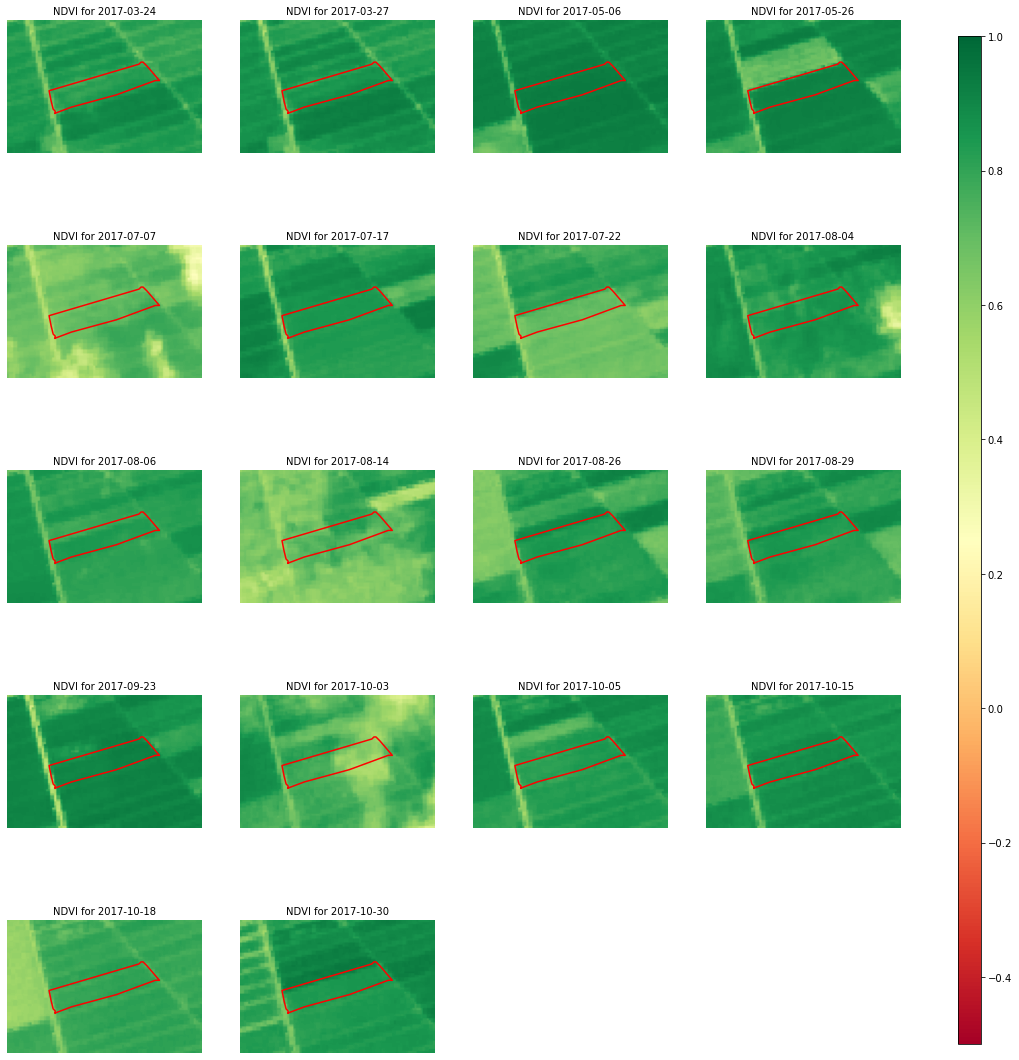

--------------------------------------------------------------------
-------------------------- parcel 21499 -----------------------------
-------------------------------------------------------------------


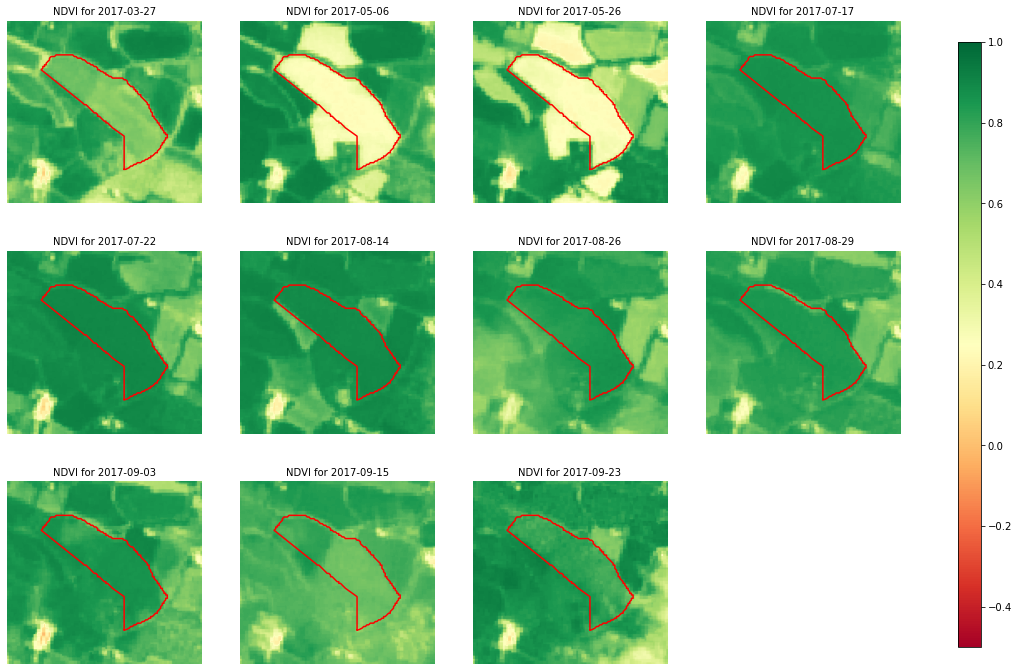

--------------------------------------------------------------------
-------------------------- parcel 37410 -----------------------------
-------------------------------------------------------------------


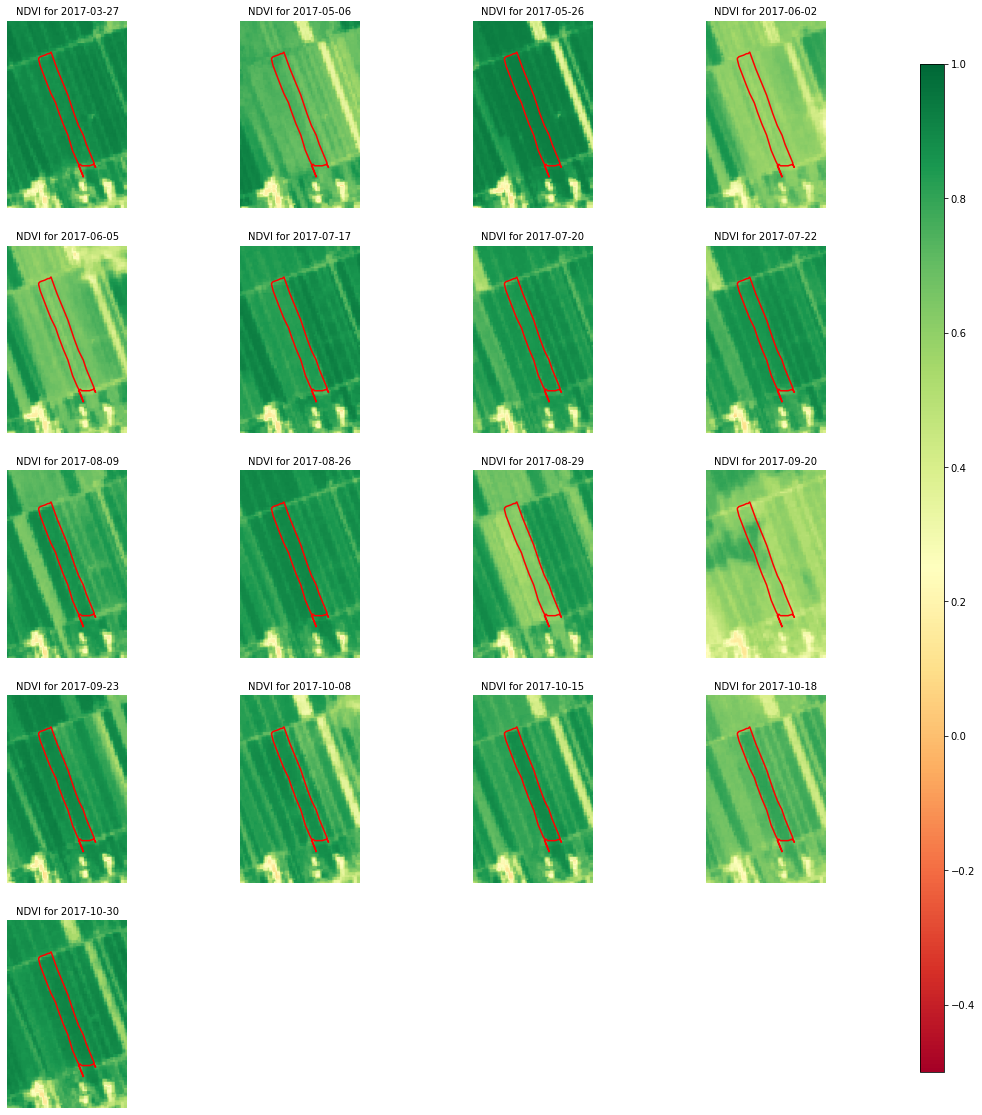

In [26]:
plot_index_multiple_parcels(geometries, geom_ids, index = 'ndvi', start_time = '2017-03-01', end_time = '2017-11-01',
                      cloud_free_percentage = 95, cols = 4, buffer = 200)


# Mapillary Streel-Level image

In [117]:
# Import some more libraries needed

import pandas_bokeh
from IPython.display import Image
from IPython.core.display import HTML 
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import bokeh.io
from bokeh.io import export_png
import requests
from tqdm.notebook import tqdm
import geopandas
from ast import literal_eval
import contextily as cx
bokeh.io.reset_output()
bokeh.io.output_notebook()

Loading BokehJS ...

In [17]:
# Load the information about the Mapillary Street Level Images.
strlev = geopandas.read_file('/data2/netherlands/Mapillary/streetLevel2017.geojson')
gdp_aoi = geopandas.read_file('/data2/netherlands/shapefiles/lpis_dandrimond_3857.shp')
gdp_aoi = gdp_aoi.to_crs("EPSG:4326") 


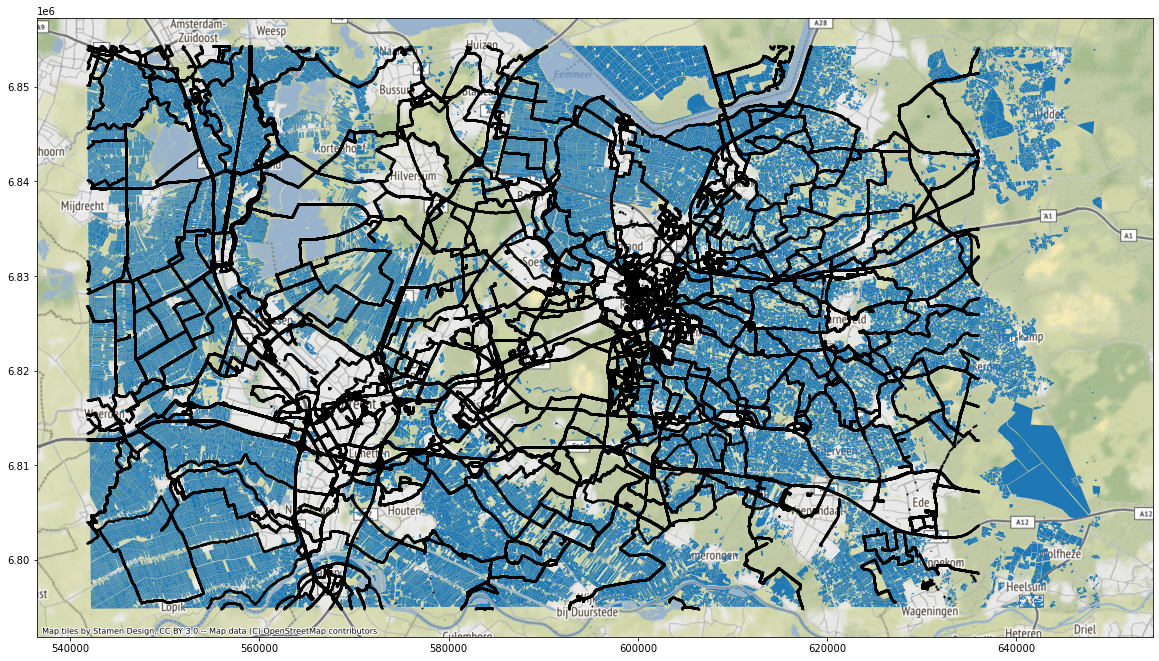

In [123]:
ax = strlev.to_crs("EPSG:3857").plot(figsize=(20, 30), color='k', zorder=2, markersize = 1)
gdp_aoi.to_crs("EPSG:3857").plot(ax=ax, zorder=1)
cx.add_basemap(ax)

In [126]:
# The .csv file below contains the predictions and declarations of each parcel, joined with 
# the neighboring Mapillary annotated street level images.
# For more information about the download and annotation process visit https://github.com/Agri-Hub/MapillaryCallisto

results = pd.read_csv("/data2/dataCAP/predictions.csv")
for col in results.columns[4:]:
    results[col] = results[col].apply(literal_eval)

In [59]:
# Left street level images of alert parcels
alert_results = results[results.id.isin(false_crops)]
alert_results_left = alert_results[alert_results.strlvl_left_keys.map(len) > 1]
alert_results_left = alert_results_left.sort_values('prob', ascending = False)

In [73]:
# Example of a 
from bokeh.io import export_png
access_token = 'MLY|4072873196100565|866bc31a02c835fe90392586268f8300'
header = {'Authorization': 'OAuth {}'.format(access_token)}

row = alert_results_left.iloc[2]
    
print("------------------------------------------------")
print("---------------- Parcel {:5d} ------------------".format(row.id))
print("Classified as \033[1m \033[92m {} \033[0m ".format(row.prediction))
print("Declared   as \033[1m \033[91m {} \033[0m ".format(row.label))
for date, image_id in zip(row.strlvl_left_dates[1:], row.left_image_ids[1:]):
    url = 'https://graph.mapillary.com/{}?fields=thumb_2048_url'.format(image_id)
    r = requests.get(url, headers=header)
    dd = r.json()
    url = dd['thumb_2048_url']
    print("----------------  {}  ------------------".format(date))
    try:
        display(Image(url=url))
    except:
        continue
    figure = strlev.loc[strlev.id == int(image_id)].plot_bokeh(show_figure=False, color = 'red', size=10, legend='Street level image')
    gdp_aoi.loc[gdp_aoi.id == row.id,['geometry']].plot_bokeh(figure = figure, legend='parcel')


------------------------------------------------
---------------- Parcel 32816 ------------------
Classified as   Grassland  
Declared   as   Maize  
----------------  2017-06-02  ------------------


----------------  2017-06-02  ------------------


----------------  2017-05-17  ------------------


----------------  2017-05-10  ------------------


----------------  2017-05-10  ------------------


----------------  2017-05-10  ------------------


----------------  2017-05-10  ------------------


----------------  2017-06-02  ------------------


----------------  2017-06-02  ------------------


--------------------------------------------------------------------
-------------------------- parcel 32816 -----------------------------
-------------------------------------------------------------------


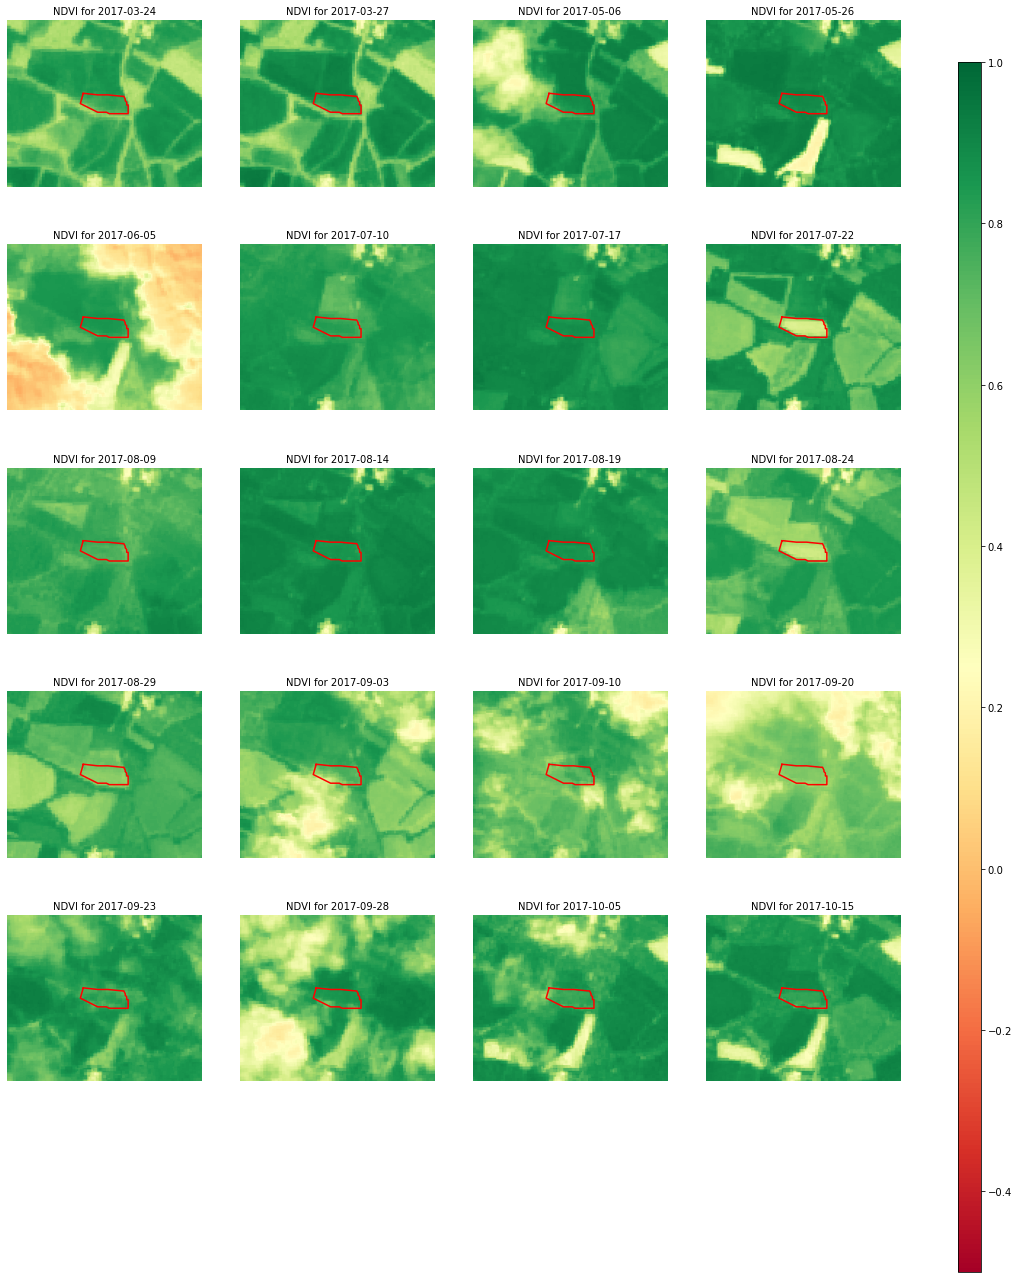

In [80]:
filename = '/data2/netherlands/shapefiles/lpis_dandrimond_3857.shp'

geometries, geom_ids = read_shapefile(shape_file = filename, selected_ids = [row.id])
plot_index_multiple_parcels(geometries, geom_ids, index = 'ndvi', start_time = '2017-03-01', end_time = '2017-11-01',
                      cloud_free_percentage = 95, cols = 4, buffer = 500)

--------------------------------------------------------------------
-------------------------- parcel 32816 -----------------------------
-------------------------------------------------------------------


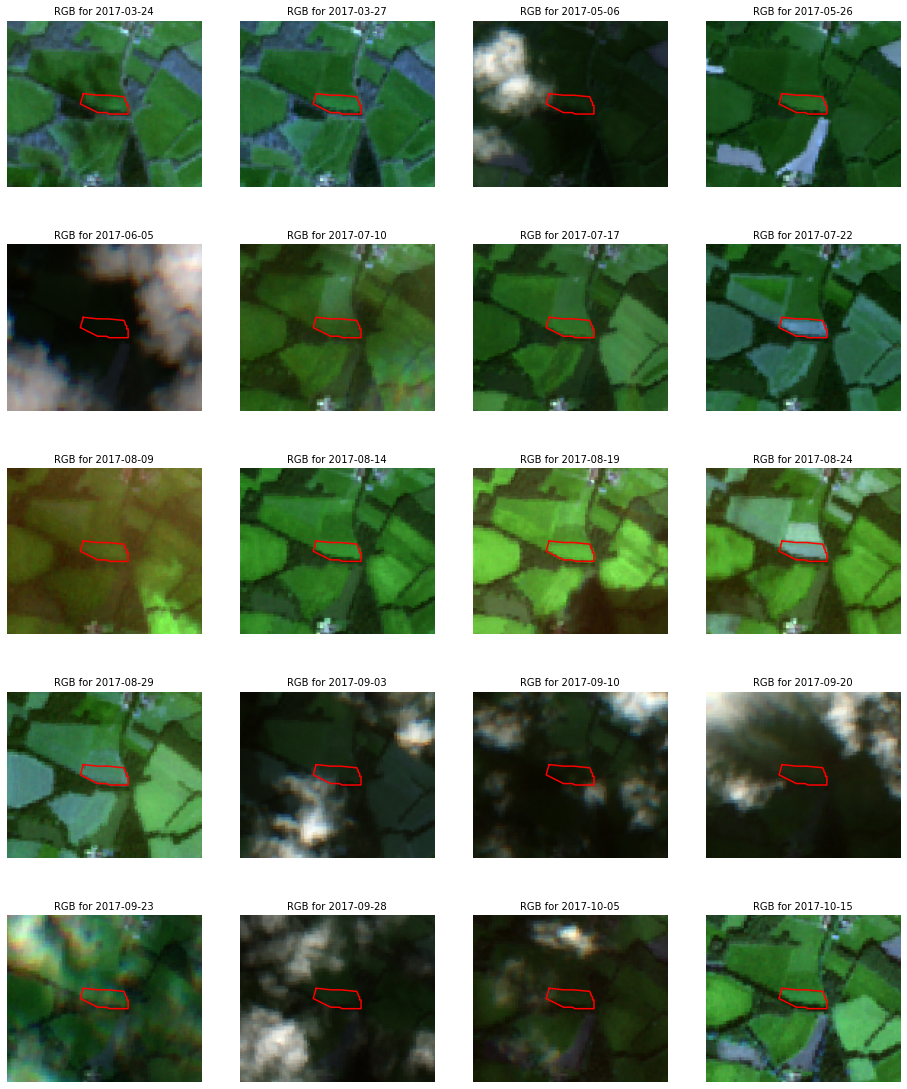

In [82]:
plot_rgb_multiple_parcels(geometries, geom_ids, start_time = '2017-03-01', end_time = '2017-11-01',
                      cloud_free_percentage = 95, cols = 4, buffer = 500)